# MPS Tutorial
This sample will show you how to use the Aria MPS data via the MPS apis.
Please refer to the MPS wiki for more information about data formats and schemas

### Notebook stuck?
Note that because of Jupyter and Plotly issues, sometimes the code may stuck at visualization. We recommend **restart the kernels** and try again to see if the issue is resolved.


## Download the MPS sample dataset locally
> The sample dataset will get downloaded to a **tmp** folder by default. Please modify the path if necessary

In [1]:
import os

from tqdm import tqdm
from urllib.request import urlretrieve
from zipfile import ZipFile

google_colab_env = 'google.colab' in str(get_ipython())
if google_colab_env:
    print("Running from Google Colab, installing projectaria_tools and getting sample data")
    !pip install projectaria-tools
    mps_sample_path = "./mps_sample_data/"
else:
    mps_sample_path = "/tmp/mps_sample_data/"

base_url = "https://www.projectaria.com/async/sample/download/?bucket=mps&filename="
os.makedirs(mps_sample_path, exist_ok=True)

filenames = [
    "sample.vrs",
    "slam_v1_1_0.zip",
    "eye_gaze_v3_1_0.zip",
    "hand_tracking_v1_0_0.zip"]

print("Downloading sample data")
for filename in tqdm(filenames):
    print(f"Processing: {filename}")
    full_path: str = os.path.join(mps_sample_path, filename)
    urlretrieve(f"{base_url}{filename}", full_path)
    if filename.endswith(".zip"):
        with ZipFile(full_path, 'r') as zip_ref:
            folder_extraction = mps_sample_path
            os.makedirs(folder_extraction, exist_ok=True)
            zip_ref.extractall(path=folder_extraction)

Running from Google Colab, installing projectaria_tools and getting sample data
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 MB 11.1 MB/s eta 0:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

Processing: sample.vrs


 25%|██▌       | 1/4 [00:06<00:20,  6.97s/it]

Processing: slam_v1_1_0.zip


 50%|█████     | 2/4 [00:09<00:08,  4.38s/it]

Processing: eye_gaze_v3_1_0.zip


 75%|███████▌  | 3/4 [00:10<00:02,  2.63s/it]

Processing: hand_tracking_v1_0_0.zip


100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


## Load the trajectory, point cloud and eye gaze using the MPS apis

In [2]:
from projectaria_tools.core import data_provider, mps
from projectaria_tools.core.mps.utils import (
    filter_points_from_confidence,
    get_gaze_vector_reprojection,
    get_nearest_eye_gaze,
    get_nearest_pose,
)
from projectaria_tools.core.stream_id import StreamId
import numpy as np

# Load the VRS file
vrsfile = os.path.join(mps_sample_path, "sample.vrs")

# Trajectory, global points, and online calibration
closed_loop_trajectory = os.path.join(
    mps_sample_path, "slam", "closed_loop_trajectory.csv"
)
global_points = os.path.join(mps_sample_path, "slam", "semidense_points.csv.gz")
online_calibrations_path = os.path.join(mps_sample_path, "slam", "online_calibration.jsonl")

# Eye gaze
generalized_eye_gaze_path = os.path.join(
    mps_sample_path, "eye_gaze", "general_eye_gaze.csv"
)
calibrated_eye_gaze_path = os.path.join(
    mps_sample_path, "eye_gaze", "personalized_eye_gaze.csv"
)

# Hand tracking
wrist_and_palm_poses_path = os.path.join(
    mps_sample_path, "hand_tracking", "wrist_and_palm_poses.csv"
)


# Create data provider and get T_device_rgb
provider = data_provider.create_vrs_data_provider(vrsfile)
# Since we want to display the position of the RGB camera, we are querying its relative location
# from the device and will apply it to the device trajectory.
T_device_RGB = provider.get_device_calibration().get_transform_device_sensor(
    "camera-rgb"
)

## Load trajectory and global points
mps_trajectory = mps.read_closed_loop_trajectory(closed_loop_trajectory)
points = mps.read_global_point_cloud(global_points)

## Load online calibration file
online_calibrations = mps.read_online_calibration(online_calibrations_path)

## Load eyegaze
generalized_eye_gazes = mps.read_eyegaze(generalized_eye_gaze_path)
calibrated_eye_gazes = mps.read_eyegaze(calibrated_eye_gaze_path)

## Load hand tracking
wrist_and_palm_poses = mps.hand_tracking.read_wrist_and_palm_poses(
    wrist_and_palm_poses_path
)

# Loaded data must be not empty
assert(
    len(mps_trajectory) != 0 and
    len(points) != 0 and
    len(online_calibrations) !=0 and
    len(generalized_eye_gazes) != 0 and
    len(calibrated_eye_gazes) != 0 and
    len(wrist_and_palm_poses) != 0)


# Or you can load the whole mps output with MpsDataProvider
mps_data_provider = mps.MpsDataProvider(mps.MpsDataPathsProvider(mps_sample_path).get_data_paths())

assert(mps_data_provider.has_general_eyegaze() and
      mps_data_provider.has_personalized_eyegaze() and
      mps_data_provider.has_open_loop_poses() and
      mps_data_provider.has_closed_loop_poses() and
      mps_data_provider.has_online_calibrations() and
      mps_data_provider.has_semidense_point_cloud() and
      mps_data_provider.has_wrist_and_palm_poses())

# Get the MPS service versions
print(f"slam_version: {mps_data_provider.get_slam_version()}")
print(f"eyegaze_version: {mps_data_provider.get_eyegaze_version()}")
print(f"hand_tracking_version: {mps_data_provider.get_hand_tracking_version()}")

slam_version: 1.1.0
eyegaze_version: 3.1.0
hand_tracking_version: 1.0.0


## Helper functions

In [3]:
import plotly.graph_objs as go
from matplotlib import pyplot as plt

# Helper function to build the frustum
def build_camera_frustum(transform_world_device):
    points = (
        np.array(
            [[0, 0, 0], [0.5, 0.5, 1], [-0.5, 0.5, 1], [-0.5, -0.5, 1], [0.5, -0.5, 1]]
        )
        * 0.6
    )
    transform_world_rgb = transform_world_device @ T_device_RGB
    points_transformed = transform_world_rgb @ points.transpose()
    return go.Mesh3d(
        x=points_transformed[0, :],
        y=points_transformed[1, :],
        z=points_transformed[2, :],
        i=[0, 0, 0, 0, 1, 1],
        j=[1, 2, 3, 4, 2, 3],
        k=[2, 3, 4, 1, 3, 4],
        showscale=False,
        visible=False,
        colorscale="jet",
        intensity=points[:, 2],
        opacity=1.0,
        hoverinfo="none",
    )

## Visualize the trajectory and point cloud in a 3D interactive plot
* Load trajectory
* Load global point cloud
* Render dense trajectory (1Khz) as points.
* Render subsampled 6DOF poses via camera frustum. Use calibration to transform RGB camera pose to world frame
* Render subsampled point cloud

_Please wait a minute for all the data to load. Zoom in to the point cloud and adjust your view. Then use the time slider to move the camera_

In [4]:
# Load all world positions from the trajectory
traj = np.empty([len(mps_trajectory), 3])
for i in range(len(mps_trajectory)):
    traj[i, :] = mps_trajectory[i].transform_world_device.translation()

# Subsample trajectory for quick display
skip = 1000
mps_trajectory_subset = mps_trajectory[::skip]
steps = [None]*len(mps_trajectory_subset)

# Load each pose as a camera frustum trace
cam_frustums = [None]*len(mps_trajectory_subset)

for i in range(len(mps_trajectory_subset)):
    pose = mps_trajectory_subset[i]
    cam_frustums[i] = build_camera_frustum(pose.transform_world_device)
    timestamp = pose.tracking_timestamp.total_seconds()
    step = dict(method="update", args=[{"visible": [False] * len(cam_frustums) + [True] * 2}, {"title": "Trajectory and Point Cloud"},], label=timestamp,)
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps[i] = step
cam_frustums[0].visible = True

# Filter the point cloud by inv depth and depth and load
points = filter_points_from_confidence(points)
# Retrieve point position
point_cloud = np.stack([it.position_world for it in points])

# Create slider to allow scrubbing and set the layout
sliders = [dict(currentvalue={"suffix": " s", "prefix": "Time :"}, pad={"t": 5}, steps=steps,)]
layout = go.Layout(
    sliders=sliders,
    scene=dict(
        bgcolor='lightgray',
        dragmode='orbit',
        aspectmode='data',
        xaxis_visible=False,
        yaxis_visible=False,
        zaxis_visible=False,
        camera=dict(
        eye=dict(x=0.5, y=0.5, z=0.5),
        center=dict(x=0, y=0, z=0),
        up=dict(x=0, y=0, z=1)
    )),
    width=1100,
    height=1000,
)

# Plot trajectory and point cloud
# We color the points by their z coordinate
trajectory = go.Scatter3d(x=traj[:, 0], y=traj[:, 1], z=traj[:, 2], mode="markers", marker={"size": 2, "opacity": 0.8, "color": "red"}, name="Trajectory", hoverinfo='none')
global_points = go.Scatter3d(x=point_cloud[:, 0], y=point_cloud[:, 1], z=point_cloud[:, 2], mode="markers",
    marker={"size" : 1.5, "color": point_cloud[:, 2], "cmin": -1.5, "cmax": 2, "colorscale": "viridis",},
    name="Global Points", hoverinfo='none')

# draw
plot_figure = go.Figure(data=cam_frustums + [trajectory, global_points], layout=layout)
plot_figure.show()

## Visualize generalized and calibrated eye gaze projection on an rgb image.
* Load Eyegaze MPS output
* Select a random RGB frame
* Find the closest eye gaze data for the RGB frame
* Project the eye gaze for the RGB frame by **using a fixed depth of 1m** or existing depth if available.
* Show the gaze cross on the RGB image

<class 'list'>


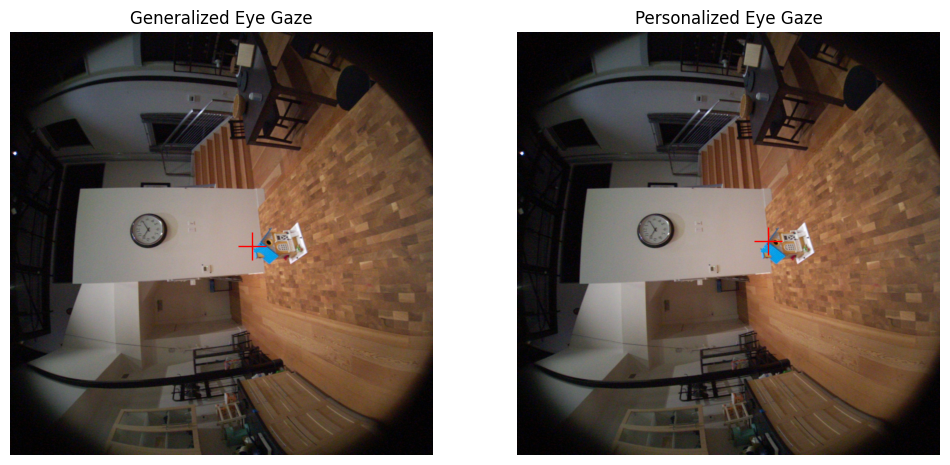

In [9]:
rgb_stream_id = StreamId("214-1")
rgb_stream_label = provider.get_label_from_stream_id(rgb_stream_id)
num_rgb_frames = provider.get_num_data(rgb_stream_id)
rgb_frame = provider.get_image_data_by_index(rgb_stream_id, (int)(num_rgb_frames-5))
assert rgb_frame[0] is not None, "no rgb frame"

image = rgb_frame[0].to_numpy_array()
capture_timestamp_ns = rgb_frame[1].capture_timestamp_ns
print(type(generalized_eye_gazes))
generalized_eye_gaze = get_nearest_eye_gaze(generalized_eye_gazes, 1762542589)
print(generalized_eye_gaze)
calibrated_eye_gaze = get_nearest_eye_gaze(calibrated_eye_gazes, capture_timestamp_ns)
# get projection function
device_calibration = provider.get_device_calibration()
camera_calibration = device_calibration.get_camera_calib(rgb_stream_label)
assert camera_calibration is not None, "no camera calibration"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

# Draw a cross at the projected gaze center location on the RGB image at available depth or if unavailable a 1m proxy
depth_m = generalized_eye_gaze.depth or 1.0
generalized_gaze_center_in_pixels = get_gaze_vector_reprojection(generalized_eye_gaze, rgb_stream_label, device_calibration, camera_calibration, depth_m)
if generalized_gaze_center_in_pixels is not None:
    ax1.imshow(image)
    ax1.plot(generalized_gaze_center_in_pixels[0], generalized_gaze_center_in_pixels[1], '+', c="red", mew=1, ms=20)
    ax1.grid(False)
    ax1.axis(False)
    ax1.set_title("Generalized Eye Gaze")
else:
    print(f"Eye gaze center projected to {generalized_gaze_center_in_pixels}, which is out of camera sensor plane.")

depth_m = calibrated_eye_gaze.depth or 1.0
calibrated_gaze_center_in_pixels = get_gaze_vector_reprojection(calibrated_eye_gaze, rgb_stream_label, device_calibration, camera_calibration, depth_m = 1.0)
if calibrated_gaze_center_in_pixels is not None:
    ax2.imshow(image)
    ax2.plot(calibrated_gaze_center_in_pixels[0], calibrated_gaze_center_in_pixels[1], '+', c="red", mew=1, ms=20)
    ax2.grid(False)
    ax2.axis(False)
    ax2.set_title("Personalized Eye Gaze")
else:
    print(f"Eye gaze center projected to {calibrated_gaze_center_in_pixels}, which is out of camera sensor plane.")

plt.show()


## Visualize wrist and palm pose projection on RGB and SLAM images

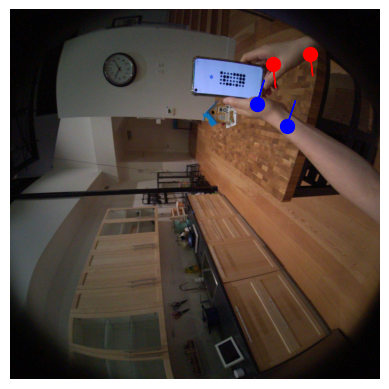

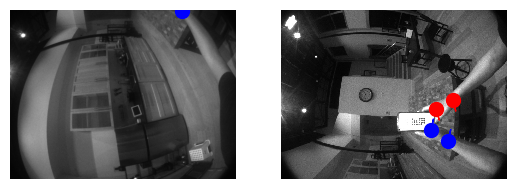

In [6]:
from typing import Dict, List, Optional

from projectaria_tools.core.calibration import CameraCalibration, DeviceCalibration
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions

time_domain: TimeDomain = TimeDomain.DEVICE_TIME
time_query_closest: TimeQueryOptions = TimeQueryOptions.CLOSEST

NORMAL_VIS_LEN = 0.05  # meters

# Get stream ids, stream labels, stream timestamps, and camera calibrations for RGB and SLAM cameras
stream_ids: Dict[str, StreamId] = {
    "rgb": StreamId("214-1"),
    "slam-left": StreamId("1201-1"),
    "slam-right": StreamId("1201-2"),
}
stream_labels: Dict[str, str] = {
    key: provider.get_label_from_stream_id(stream_id)
    for key, stream_id in stream_ids.items()
}
stream_timestamps_ns: Dict[str, List[int]] = {
    key: provider.get_timestamps_ns(stream_id, time_domain)
    for key, stream_id in stream_ids.items()
}
camera_calibrations = {
    key: device_calibration.get_camera_calib(stream_label)
    for key, stream_label in stream_labels.items()
}
for key, camera_calibration in camera_calibrations.items():
    assert camera_calibration is not None, f"no camera calibration for {key}"

# Get device calibration and transform from device to sensor
device_calibration = provider.get_device_calibration()


def get_T_device_sensor(key: str):
    return device_calibration.get_transform_device_sensor(stream_labels[key])


# Get a sample frame for each of the RGB, SLAM left, and SLAM right streams
sample_timestamp_ns: int = stream_timestamps_ns["rgb"][120]
sample_frames = {
    key: provider.get_image_data_by_time_ns(
        stream_id, sample_timestamp_ns, time_domain, time_query_closest
    )[0]
    for key, stream_id in stream_ids.items()
}

# Get the wrist and palm pose
wrist_and_palm_pose = mps_data_provider.get_wrist_and_palm_pose(
    sample_timestamp_ns, time_query_closest
)


# Helper functions for reprojection and plotting
def get_point_reprojection(
    point_position_device: np.array, key: str
) -> Optional[np.array]:
    point_position_camera = get_T_device_sensor(key).inverse() @ point_position_device
    point_position_pixel = camera_calibrations[key].project(point_position_camera)
    return point_position_pixel


def get_wrist_and_palm_pixels(key: str) -> np.array:
    left_wrist = get_point_reprojection(
        wrist_and_palm_pose.left_hand.wrist_position_device, key
    )
    left_palm = get_point_reprojection(
        wrist_and_palm_pose.left_hand.palm_position_device, key
    )
    right_wrist = get_point_reprojection(
        wrist_and_palm_pose.right_hand.wrist_position_device, key
    )
    right_palm = get_point_reprojection(
        wrist_and_palm_pose.right_hand.palm_position_device, key
    )
    left_wrist_normal_tip = None
    left_palm_normal_tip = None
    right_wrist_normal_tip = None
    right_palm_normal_tip = None
    left_normals = wrist_and_palm_pose.left_hand.wrist_and_palm_normal_device
    if left_normals is not None:
        left_wrist_normal_tip = get_point_reprojection(
            wrist_and_palm_pose.left_hand.wrist_position_device
            + wrist_and_palm_pose.left_hand.wrist_and_palm_normal_device.wrist_normal_device
            * NORMAL_VIS_LEN,
            key,
        )
        left_palm_normal_tip = get_point_reprojection(
            wrist_and_palm_pose.left_hand.palm_position_device
            + wrist_and_palm_pose.left_hand.wrist_and_palm_normal_device.palm_normal_device
            * NORMAL_VIS_LEN,
            key,
        )
    right_normals = wrist_and_palm_pose.right_hand.wrist_and_palm_normal_device
    if right_normals is not None:
        right_wrist_normal_tip = get_point_reprojection(
            wrist_and_palm_pose.right_hand.wrist_position_device
            + wrist_and_palm_pose.right_hand.wrist_and_palm_normal_device.wrist_normal_device
            * NORMAL_VIS_LEN,
            key,
        )
        right_palm_normal_tip = get_point_reprojection(
            wrist_and_palm_pose.right_hand.palm_position_device
            + wrist_and_palm_pose.right_hand.wrist_and_palm_normal_device.palm_normal_device
            * NORMAL_VIS_LEN,
            key,
        )
    return (
        left_wrist,
        left_palm,
        right_wrist,
        right_palm,
        left_wrist_normal_tip,
        left_palm_normal_tip,
        right_wrist_normal_tip,
        right_palm_normal_tip,
    )


def plot_wrists_and_palms(
    plt,
    left_wrist,
    left_palm,
    right_wrist,
    right_palm,
    left_wrist_normal_tip,
    left_palm_normal_tip,
    right_wrist_normal_tip,
    right_palm_normal_tip,
):
    def plot_point(point, color):
        plt.plot(*point, ".", c=color, mew=1, ms=20)

    def plot_arrow(point, vector, color):
        plt.arrow(*point, *vector, color=color)

    if left_wrist is not None:
        plot_point(left_wrist, "blue")
    if left_palm is not None:
        plot_point(left_palm, "blue")
    if right_wrist is not None:
        plot_point(right_wrist, "red")
    if right_palm is not None:
        plot_point(right_palm, "red")
    if left_wrist_normal_tip is not None:
        plot_arrow(left_wrist, left_wrist_normal_tip - left_wrist, "blue")
    if left_palm_normal_tip is not None:
        plot_arrow(left_palm, left_palm_normal_tip - left_palm, "blue")
    if right_wrist_normal_tip is not None:
        plot_arrow(right_wrist, right_wrist_normal_tip - right_wrist, "red")
    if right_palm_normal_tip is not None:
        plot_arrow(right_palm, right_palm_normal_tip - right_palm, "red")


# Display wrist and palm positions on RGB, SLAM left, and SLAM right images
plt.figure()
rgb_image = sample_frames["rgb"].to_numpy_array()
plt.grid(False)
plt.axis("off")
plt.imshow(rgb_image)
(
    left_wrist,
    left_palm,
    right_wrist,
    right_palm,
    left_wrist_normal,
    left_palm_normal,
    right_wrist_normal,
    right_palm_normal,
) = get_wrist_and_palm_pixels("rgb")
plot_wrists_and_palms(
    plt,
    left_wrist,
    left_palm,
    right_wrist,
    right_palm,
    left_wrist_normal,
    left_palm_normal,
    right_wrist_normal,
    right_palm_normal,
)

plt.figure()
plt.subplot(1, 2, 1)
slam_left_image = sample_frames["slam-left"].to_numpy_array()
plt.grid(False)
plt.axis("off")
plt.imshow(slam_left_image, cmap="gray", vmin=0, vmax=255)
(
    left_wrist,
    left_palm,
    right_wrist,
    right_palm,
    left_wrist_normal,
    left_palm_normal,
    right_wrist_normal,
    right_palm_normal,
) = get_wrist_and_palm_pixels("slam-left")
plot_wrists_and_palms(
    plt,
    left_wrist,
    left_palm,
    right_wrist,
    right_palm,
    left_wrist_normal,
    left_palm_normal,
    right_wrist_normal,
    right_palm_normal,
)


plt.subplot(1, 2, 2)
slam_right_image = sample_frames["slam-right"].to_numpy_array()
plt.grid(False)
plt.axis("off")
plt.imshow(slam_right_image, interpolation="nearest", cmap="gray")
(
    left_wrist,
    left_palm,
    right_wrist,
    right_palm,
    left_wrist_normal,
    left_palm_normal,
    right_wrist_normal,
    right_palm_normal,
) = get_wrist_and_palm_pixels("slam-right")
plot_wrists_and_palms(
    plt,
    left_wrist,
    left_palm,
    right_wrist,
    right_palm,
    left_wrist_normal,
    left_palm_normal,
    right_wrist_normal,
    right_palm_normal,
)
plt.show()

## Examples for using the Online calibration from MPS

`online_calibration.jsonl` contains one json online calibration record per line. Each record is a json dict object that contains timestamp metadata and the result of online calibration for the cameras and IMUs. Note that after the v1.1.0 MPS SLAM release, we improved the RGB camera online calibration for time offsets estimation, intrinsics/extrinsics estimation, as well as exposing the image readout time for compensating the rolling shutter effect.

The following example shows how to read the online calibrated parameters, and the difference of an RGB image undistorted with and without online calibration.

The online calibration estimated better timestamp for rgb mid exposure time is 1793806674574ns vs 1793804174575ns with offset 2499999ns


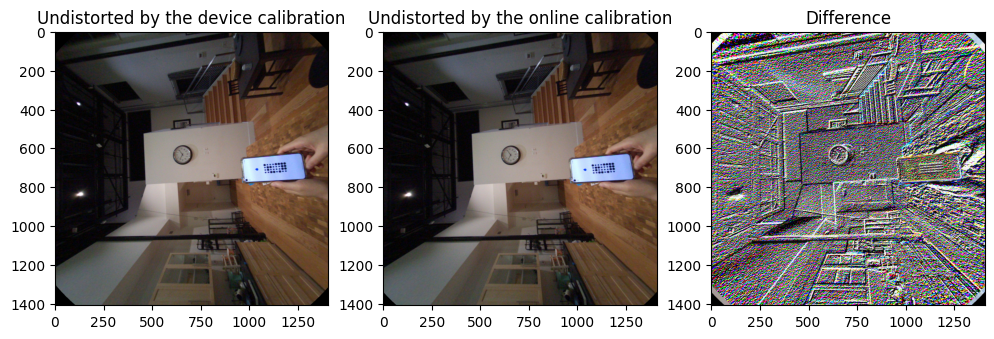

Rgb camera take 0.004999999888241291 seconds to read out the image


In [7]:
from projectaria_tools.core import calibration

rgb_stream_id = StreamId("214-1")
rgb_stream_label = provider.get_label_from_stream_id(rgb_stream_id)
num_rgb_frames = provider.get_num_data(rgb_stream_id)
rgb_frame = provider.get_image_data_by_index(rgb_stream_id, (int)(num_rgb_frames / 2))
assert rgb_frame[0] is not None, "no rgb frame"

image = rgb_frame[0].to_numpy_array()
capture_timestamp_ns = rgb_frame[1].capture_timestamp_ns

# get the online calibration RGB projection function
corrected_rgb_timestamp_ns = mps_data_provider.get_rgb_corrected_timestamp_ns(capture_timestamp_ns)

print("The online calibration estimated better timestamp for rgb mid exposure",
      f"time is {corrected_rgb_timestamp_ns}ns vs {capture_timestamp_ns}ns with",
      f"offset {corrected_rgb_timestamp_ns - capture_timestamp_ns}ns")


# Example API to get the online calibrated RGB pose
corrected_rgb_pose = mps_data_provider.get_rgb_corrected_closed_loop_pose(capture_timestamp_ns)

# Get the online calibration for rgb camera and undistort the image using it
online_camera_calibration = mps_data_provider.get_online_calibration(capture_timestamp_ns).get_camera_calib(rgb_stream_label)
rgb_linear_camera_calibration_online = calibration.get_linear_camera_calibration(
    int(online_camera_calibration.get_image_size()[0]),
    int(online_camera_calibration.get_image_size()[1]),
    online_camera_calibration.get_focal_lengths()[0],
    "pinhole",
    online_camera_calibration.get_transform_device_camera(),
)
undistort_image_online = calibration.distort_by_calibration(
                image,
                rgb_linear_camera_calibration_online,
                online_camera_calibration,
            )

# get projection function from device factory calibration and undistort the image using it
device_calibration = provider.get_device_calibration()
camera_calibration = device_calibration.get_camera_calib(rgb_stream_label)
rgb_linear_camera_calibration = calibration.get_linear_camera_calibration(
    int(camera_calibration.get_image_size()[0]),
    int(camera_calibration.get_image_size()[1]),
    camera_calibration.get_focal_lengths()[0],
    "pinhole",
    camera_calibration.get_transform_device_camera(),
)
undistort_image = calibration.distort_by_calibration(
                image,
                rgb_linear_camera_calibration,
                camera_calibration,
            )

# Compute the difference between the two images
diff_image = undistort_image - undistort_image_online
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# Plot the first image
axs[0].imshow(undistort_image)
axs[0].set_title('Undistorted by the device calibration')
# Plot the second image
axs[1].imshow(undistort_image_online)
axs[1].set_title('Undistorted by the online calibration')
# Plot the difference image
axs[2].imshow(diff_image)
axs[2].set_title('Difference')
# Show the plot
plt.show()

# Note that the rgb image read out time is available now for rolling shutter handling
print(f"Rgb camera take {online_camera_calibration.get_readout_time_sec()} seconds to read out the image")